# Electron capture via Sn_Zn in CZTS

This notebook demonstrates some basic features of `CarrierCapture`, a set of codes to compute carrier capture and recombination rates in semiconducting compounds. 

It was written on 10-Mar-2020 for v0.2, but checked on 11-Mar-2025 with v0.7. See more in [J. Mater. Chem. A 7, 2686 (2019)](https://pubs.rsc.org/en/content/articlelanding/2019/ta/c8ta10130b).

## Overview

In this notebook, we will:

1. Find a best fit for the energy calculations of the deferomed structures (potential) to generate potential energy surfaces (PES). Solve the 1D Schrödinger equation for each PES to obtain their phonon (nuclear) wavefunctions.

2. Construct configuration coordinate (conf_coord) to calculate the wavefunction overlap between each PES, which forms part of the temperature-dependent capture coefficient.

# Setup

`CarrierCapture` is written in the Julia language, so make sure that [Julia](https://julialang.org/downloads) is installed. To run the notebook, you will need to install the `IJulia` package:

```bash
import Pkg
Pkg.add("IJulia")
```

and may also require the VS Code Julia extension (or similar) to enable a Julia kernel. To install from scratch:

In [ ]:
# Run if installing from scratch 
import Pkg
Pkg.add(Pkg.PackageSpec(url="https://github.com/WMD-group/CarrierCapture.jl.git"))
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("DataFrames")

In [ ]:
# Load packages and check version
using CarrierCapture
using Plots, LaTeXStrings
using DataFrames, Printf
@show VERSION

VERSION = v"1.11.4"


v"1.11.4"

# Potentials

The domain of PES (`Q`) is defined. Make sure all relevent wave functions are in the domain.

In [2]:
Qmin = -25
Qmax = 35
NQ = 3000
Q = range(Qmin, stop=Qmax, length=NQ)

-25.0:0.020006668889629875:35.0

Find a best fit for the energy calculations of the deferomed structures (potential) to generate potential energy surfaces (PES). 
Here we using [spline interpolation](https://en.wikipedia.org/wiki/Spline_interpolation) to find their best fit.

In [3]:
# pot1
nev = 30
name = "SnII+e+h"

pot1 = Potential(); pot1.name = name
pot1.Q0 = 0; pot1.E0 = 1.46
pot1.nev = nev
pot1.func_type = "harmonic"
params = Dict()
params["hw"] = 0.0288945775003
pot1.Q = Q
pot1.params = params
fit_pot!(pot1)
# pot1.func = x -> harmonic(x, 0.0288945775003; E₀ = pot1.E0, Q₀ = pot1.Q0)
# pot1.Q = Q
# pot1.E = pot1.func.(Q)


# pot2
nev = 40
name = "SnIII+h"

pot2 = Potential(); pot2.name = name
pot2.Q0 = 1.90291674728; pot2.E0 = 0.585005
pot2.nev = nev
pot2.func_type = "harmonic"
params = Dict()
params["hw"] = 0.0281812646475
pot2.Q = Q
pot2.params = params
fit_pot!(pot2)
# pot2.func = x -> harmonic(x, 0.1281812646475; E₀ = pot2.E0, Q₀ = pot2.Q0)
# pot2.Q = Q
# pot2.E = pot2.func.(Q)


# pot3
nev = 30
hw = 0.0288945775003
name = "SnII"

pot3 = Potential(); pot3.name = name
pot3.Q0 = 0; pot3.E0 = 0
pot3.nev = nev
pot3.func_type = "harmonic"
params = Dict()
params["hw"] = 0.0288945775003
pot3.Q = Q
pot3.params = params
fit_pot!(pot3)
# pot3.func = x -> harmonic(x, 0.0288945775003; E₀ = pot3.E0, Q₀ = pot3.Q0)
# pot3.Q = Q
# pot3.E = pot3.func.(Q)
"Fitting completed"

Potential fitting: SnII+e+h
========harmonic=========

Potential fitting: SnIII+h
========harmonic=========

Potential fitting: SnII
========harmonic=========



"Fitting completed"

The next step is solving the 1D Schrödinger equation for each PES to obtain their phonon (nuclear) wavefunctions.

In [ ]:
# Solve Schrödinger equation
solve_pot!(pot1)
solve_pot!(pot2)
solve_pot!(pot3)
"Schrödinger equation solved"

"Schrödinger equation solved"

### Capture barriers

The classic energy barrier to capture an electron or a hole can be calculated using `find_crossing` function.

In [7]:
Qx, Ex = find_crossing(pot2, pot3)
@printf("Hole capture barrier: %.3f eV\n", Ex - pot2.E0)

Qx, Ex = find_crossing(pot1, pot2)
@printf("Electron capture barrier: %.3f eV\n", Ex - pot1.E0)

Hole capture barrier: 0.032 eV
Electron capture barrier: 0.224 eV


### Potentials and associated wave functions 

Plotting the potential energy surfaces and associated wave functions can help you to understand what is happening. Make sure you calculated an enough number of state (`nev`) to describe the carrier-cature behavior.

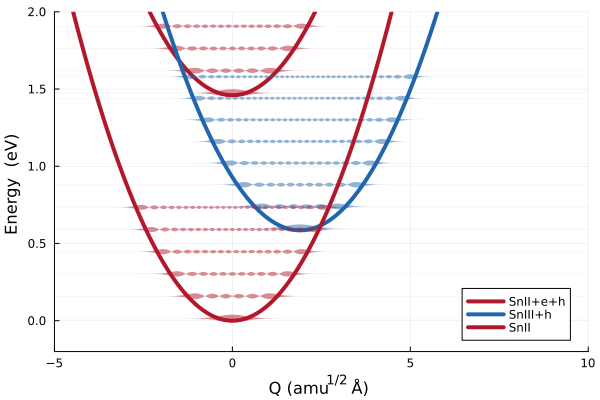

In [13]:
plt = plot()
Plotter.plot_pot!(pot1; lplt_wf = true, plt = plt, color = "#b2182b")
Plotter.plot_pot!(pot2; lplt_wf = true, plt = plt, color = "#2166ac")
Plotter.plot_pot!(pot3; lplt_wf = true, plt = plt, color = "#b2182b")
xlims!((-5, 10))
ylims!((-0.2, 2))

# Capture coefficient

Define parameters for calculating capture coefficient (e.g. temperature and Volume of the supercell).

In [9]:
Tmin = 10
Tmax = 800
NT = 100
Volume = 1.28463E-21
cut_off = 0.25
σ = 0.0075
temperature = range(Tmin, stop=Tmax, length=NT)

10.0:7.97979797979798:800.0

Constructe configuration coordinate (`conf_coord`) to calculate the wavefunction overlap between each PES, which forms part of the temperature-dependent capture coefficient.
The capture coefficient is given as a function of temperature.

## Electron capture

In [11]:
W = 0.205 # e-ph coupling
g = 1 # degeneracy

# build a configuration coordinate for the electron capture
cc_e = conf_coord(pot1, pot2)
cc_e.W = W
cc_e.g = g
calc_overlap!(cc_e; cut_off = cut_off, σ = σ, Q₀ = pot1.Q0)
calc_capt_coeff!(cc_e, Volume, temperature)

10.0:7.97979797979798:800.0

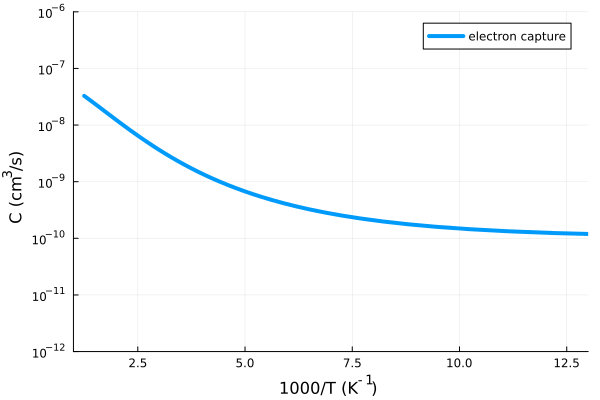

In [12]:
invTmin = 1
invTmax = 13

plt = plot()

Plotter.plot_cc!(cc_e; plt=plt, label="electron capture")

xlims!(invTmin, invTmax)
ylims!(1E-12, 1E-6)